## Control: Correlate cost profiles with shuffled sequences

```bash
python scripts/extract_attention_patterns_shuffled.py \
  -c results/20240528_151534/experiment_config.yaml
```

In [1]:
from multiprocessing import cpu_count
import os
import yaml

import numexpr
import numpy as np
import pandas as pd
import scipy.stats as stats
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from scripts.general import attribution, data

tqdm.pandas(desc='Pandas op')
# numexpr.set_num_threads(cpu_count() - 2)


def left_align(df: pd.DataFrame):
    """https://stackoverflow.com/a/63869860"""
    left_aligned_df = df.style.set_properties(**{'text-align': 'left'})
    left_aligned_df = left_aligned_df.set_table_styles(
        [dict(selector='th', props=[('text-align', 'left')])]
    )
    return left_aligned_df

## Load data and construct seq cost

In [2]:
exp_dir = './'

In [3]:
from Bio.PDB.Polypeptide import three_to_one

with open(exp_dir + 'experiment_config.yaml', 'r') as config_file:
    config = yaml.load(config_file, Loader=yaml.FullLoader)
    
seq_data = data.load_seq_and_abundance_data(config)
seq_data = seq_data.assign(seq_len = seq_data['seq'].str.len())

sequence = dict(seq_data[['swissprot_ac', 'seq']].values)

aa_costs = pd.read_csv('../../data/aa_costs/aa_costs_barton.csv')
aa_costs['amino_acid'] = aa_costs['amino_acid'].map(lambda aa: three_to_one(aa.upper()))
aa_costs = aa_costs.drop(
    columns=['ecoli_car_abs', 'ecoli_car_rel', 'ecoli_nit_abs', 'ecoli_nit_rel', 'ecoli_sul_abs', 'ecoli_sul_rel',
             'yeast_sul_rel', 'yeast_sul_abs']
)
cost_names = list(filter(lambda name: name != 'amino_acid', aa_costs.columns))

In [4]:
cost_descr = { 
    'akashi': 'Energetic cost (avg. n. units of high energy P bonds and reducing H atoms) [Akashi & Gojobori 2002]',
    'craig_energy': 'Energetic cost (avg. n. units of high energy P bonds and reducing H atoms) [Craig & Weber 1998]',
    'craig_steps': 'The number of biosynthetic steps between central metabolism and the resulting AA [Craig & Weber 1998]',
    'wagner_ferm': 'Fermentative cost (similar to Craig & Weber) [Wagner 2005]',
    'wagner_resp': 'Respiratory cost (similar to Craig & Weber) [Wagner 2005]',
    'weight': 'Molecular weight of the amino acid [Seligmann 2003]',
    'yeast_car_abs': 'Imapct of abs. change of the AA requirement on the minimal intake of C (glucose) [Barton et al. 2010]',
    'yeast_car_rel': 'Imapct of rel. change of the AA requirement on the minimal intake of C (glucose) [Barton et al. 2010]',
    'yeast_nit_abs': 'Imapct of abs. change of the AA requirement on the minimal intake of N (ammonium) [Barton et al. 2010]',
    'yeast_nit_rel': 'Imapct of rel. change of the AA requirement on the minimal intake of N (ammonium) [Barton et al. 2010]',
#     'yeast_sul_abs': 'Imapct of abs. change of the AA requirement on the minimal intake of S (sulphate) [Barton et al. 2010]',
#     'yeast_sul_rel': 'Imapct of rel. change of the AA requirement on the minimal intake of S (sulphate) [Barton et al. 2010]'
}

cost_descr = pd.DataFrame.from_records(list(cost_descr.items()), columns = ['cost', 'descr'])
cost_descr['descr'] = cost_descr['descr'].map(lambda s: str.ljust(s, 120))

In [5]:
print('N. seq: ', seq_data.shape[0])

N. seq:  4750


In [6]:
print('Bonferroni-corrected p-values =', 0.05 / seq_data.shape[0])

Bonferroni-corrected p-values = 1.0526315789473684e-05


In [7]:
#         pvalue_threshold = 0.05 / seq_data.shape[0]
pvalue_threshold = 1e6

In [8]:
def sequence_cost(seq, cost_name):
    cost_of_aa = dict(aa_costs[['amino_acid', cost_name]].values)
    cost = list(map(lambda aa: cost_of_aa[aa], seq))
    return np.array(cost, dtype=np.float32)


def calc_profile_attention_corr(protein_id: str) -> float:
    """
    Return highest absolute correlation between any of the proteins attention profiles
    and each sequence cost
    """    
    # Multiple profiles for a sequence
    attention_profiles, _ = attribution.load_profiles(protein_id, exp_dir)
    
    costs_for_protein = {}
    for cost_name in cost_names:
        # Calc corr between all profiles and this cost
        seq_cost = sequence_cost(sequence[protein_id], cost_name)
        
        attention_corr = np.apply_along_axis(
            lambda profile: stats.pearsonr(profile, seq_cost),
            axis = 1,
            arr = attention_profiles
        )
    
        # Keep only significant corr (low p-value) with Bonferroni correction
        signif_att_corr = attention_corr[attention_corr[:, 1] < pvalue_threshold]
        signif_att_corr = signif_att_corr[:, 0]

        # Return max absolute value
        if signif_att_corr.shape[0] > 0:
            costs_for_protein[cost_name] =  max(signif_att_corr.min(), signif_att_corr.max(), key=abs)
        else:
            costs_for_protein[cost_name] = None

    costs_for_protein = pd.DataFrame.from_records(list(costs_for_protein.items()),
                                                  columns=['cost', 'corr'])
    costs_for_protein['corr'] = costs_for_protein['corr'].astype('float32')
    costs_for_protein = costs_for_protein.assign(swissprot_ac = protein_id)
    return costs_for_protein[['swissprot_ac', 'cost', 'corr']]


cost_correlations = seq_data['swissprot_ac'].progress_map(
    calc_profile_attention_corr
)
cost_correlations = pd.concat(cost_correlations.values, ignore_index=True)

Pandas op:   0%|          | 0/4750 [00:00<?, ?it/s]

In [11]:
cost_correlations['corr'].abs().mean()

0.08022572

In [12]:
cost_correlations['corr'].abs().std()

0.043483056

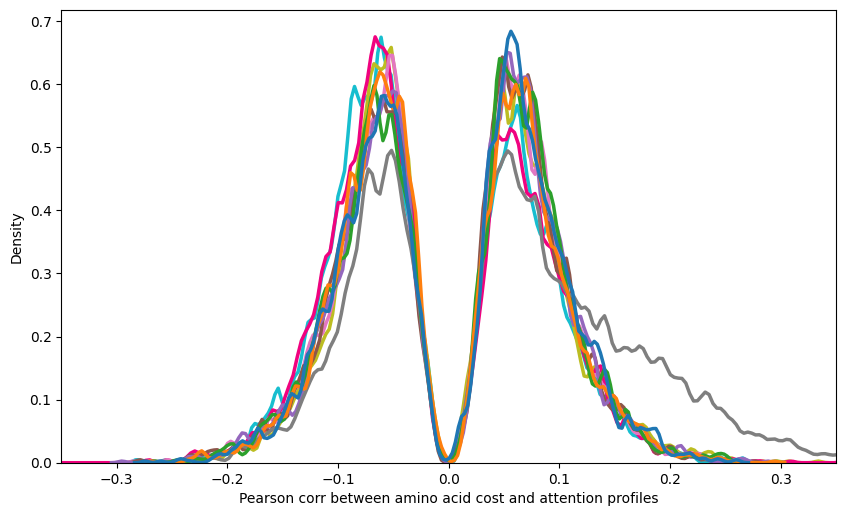

In [13]:
plt.figure(dpi = 100, figsize = (10, 6))

palette = sns.color_palette('tab10')
palette[3] = sns.color_palette('Accent')[-3]  # avoid pure red for colorblindness
palette[3], palette[7] = palette[7], palette[3]


g = sns.kdeplot(data = cost_correlations, x = 'corr', hue='cost',
                bw_adjust=0.2,
                linewidth = 2.5, 
                legend=False,
                palette=palette)

g.set(xlim=(-0.35, 0.35))

plt.xlabel('Pearson corr between amino acid cost and attention profiles');

## Overlap with correlations of real sequences

In [15]:
real_corr = pd.read_csv('../20211223_182228/att_cost_corr.csv')

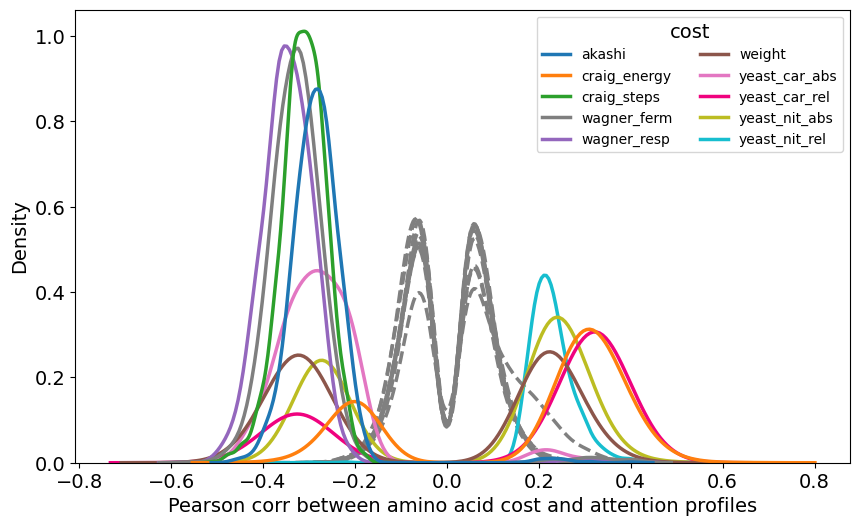

In [26]:
plt.rcParams['font.size'] = 14
plt.figure(dpi = 100, figsize = (10, 6))

palette = sns.color_palette('tab10')
palette[3] = sns.color_palette('Accent')[-3]  # avoid pure red for colorblindness
palette[3], palette[7] = palette[7], palette[3]

control_palette = sns.color_palette(['grey'], len(cost_correlations['cost'].unique()))

sns.kdeplot(data = cost_correlations, x = 'corr', hue='cost',
            linewidth = 2.5, 
            ls='--',
            legend=False,
            palette=control_palette)

g = sns.kdeplot(data = real_corr, x = 'corr', hue='cost', 
            linewidth = 2.5, 
            palette=palette)

sns.move_legend(g, loc='upper right', ncol = 2, fontsize=10)

plt.xlabel('Pearson corr between amino acid cost and attention profiles');

plt.savefig('attention_cost_corr_with_controls.pdf')